# SVM and SVM rejection 



In [6]:
import os 
import numpy as np
import pandas as pd
import scanpy as sc
import time as tm
import seaborn as sns
from sklearn.svm import LinearSVC
import rpy2.robjects as robjects
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from scanpy import read_h5ad
import scipy
#os.chdir("")

## Defining the SVM and SVMrej functions:



In [7]:
def run_SVM(matrix_train, matrix_test, LabelsPathTrain, OutputDir):
    '''
    run baseline classifier: SVM
    Wrapper script to run an SVM classifier with a linear kernel on a benchmark dataset with 5-fold cross validation,
    outputs lists of true and predicted cell labels as csv files, as well as computation time.

    Parameters:
    matrix_train, matrix_test : Data matrix for training and testing data,
        cells-genes matrix with cell unique barcodes as row names and gene names as column names.
    LabelsPathTrain : Cell population annotations file path matching the training data (.csv).
    OutputDir : Output directory defining the path of the exported file.
    '''


    # read the data
    data_train = matrix_train
    data_test = matrix_test
    labels_train = pd.read_csv(LabelsPathTrain, header=0,index_col=None, sep=',')
        

    # normalise data
    data_train = np.log1p(data_train)
    data_test = np.log1p(data_test)  
        
    Classifier = LinearSVC()
    pred = []
    Classifier.fit(data_train, labels_train.values.ravel())

    predicted = Classifier.predict(data_test)
            
    pred.extend(predicted)
    pred = pd.DataFrame(pred)
    pred.to_csv(str(OutputDir) + "SVM_Pred_Labels.csv", index =False)
    
    
    

In [8]:
def run_SVMrej(matrix_train, matrix_test, LabelsPathTrain, OutputDir, Threshold = 0.7):
    '''
    run baseline classifier: SVM
    Wrapper script to run an SVM classifier with a linear kernel on a benchmark dataset with 5-fold cross validation,
    outputs lists of true and predicted cell labels as csv files, as well as computation time.
  
    Parameters
    ----------
    matrix_train, matrix_test : Data matrix for training and testing data,
        cells-genes matrix with cell unique barcodes as row names and gene names as column names.
    LabelsPathTrain : Cell population annotations file path matching the training data (.csv).
    OutputDir : Output directory defining the path of the exported file.
    Threshold : Threshold used when rejecting the cells, default is 0.7.
    '''


    # read the data
    data_train = matrix_train
    data_test = matrix_test
    labels_train = pd.read_csv(LabelsPathTrain, header=0,index_col=None, sep=',')
    
    # Set threshold for rejecting cells
    Threshold = 0.3

    # normalise data
    data_train = np.log1p(data_train)
    data_test = np.log1p(data_test) 
        
    Classifier = LinearSVC()
    clf = CalibratedClassifierCV(Classifier, cv=3)

    pred = []
    probability = [] 
    
    clf.fit(data_train, labels_train.values.ravel())
    predicted = clf.predict(data_test)
    prob = np.max(clf.predict_proba(data_test), axis = 1)
    unlabeled = np.where(prob < Threshold)
    predicted[unlabeled] = 'Unknown'
        
    pred.extend(predicted)
    probability.extend(prob)
    
    pred = pd.DataFrame(pred)
    probability = pd.DataFrame(probability)
    
    pred.to_csv(str(OutputDir) + "SVMrej_Pred_Labels.csv", index = False)
    probability.to_csv(str(OutputDir) + "SVMrej_Prob.csv", index = False)
    

## Annotate:

Annotate Jos data from meta atlas

In [4]:
training = read_h5ad("/ceph/rimlsfnwi/data/moldevbio/zhou/jarts/jupyter_notebooks/test_dat_meta.h5ad")
#Specify jupyter notebook path of supervisor Julian above
testing = read_h5ad("/ceph/rimlsfnwi/data/moldevbio/zhou/imarais/jupyter_notebook/data/results/scanpy_dev_cornea_1_to_17.h5ad") #Use concatenated dataset for RNA = later dataset
#Specify embryonic datasets (RNA), including the file name

In [5]:
testing.obs

,type,sample,time_point,batch,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,...,n_counts,n_genes,percent_chrY,XIST-counts,S_score,G2M_score,phase,doublet_scores,predicted_doublets,doublet_info
AAACGAACATTGAAGA-1-0,dev_cornea,dc1,10PCW,0,2730,8938.0,349.0,3.904677,2712.0,30.342358,...,8589.0,2730,0.000000,3.0,-0.621783,-0.741423,G1,0.108108,False,False
AAAGTCCAGAAAGTCT-1-0,dev_cornea,dc1,10PCW,0,3398,11587.0,387.0,3.339950,3320.0,28.652800,...,11200.0,3398,0.000000,1.0,-0.787741,-1.115565,G1,0.076923,False,False
AAAGTGAAGCGCACAA-1-0,dev_cornea,dc1,10PCW,0,2341,7676.0,407.0,5.302241,2203.0,28.699844,...,7269.0,2341,0.000000,2.0,-0.622999,-0.643734,G1,0.085937,False,False
AAAGTGACAGTTGCGC-1-0,dev_cornea,dc1,10PCW,0,1542,3338.0,193.0,5.781905,733.0,21.959257,...,3145.0,1542,0.000000,2.0,-0.236170,-0.247923,G1,0.055556,False,False
AACAAGAAGCGAATGC-1-0,dev_cornea,dc1,10PCW,0,1998,5283.0,88.0,1.665720,1654.0,31.307968,...,5195.0,1998,0.000000,2.0,-0.578014,-0.423619,G1,0.085937,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCACACTTAG-1-16,dev_cornea,dc17,21PCW,16,2719,6286.0,639.0,10.165447,600.0,9.545021,...,5646.0,2719,0.017712,0.0,-0.851976,-0.414139,G1,0.033866,False,False
TTTGTTGGTAAGGTCG-1-16,dev_cornea,dc17,21PCW,16,5082,17376.0,1974.0,11.360497,3156.0,18.162983,...,15402.0,5082,0.110375,0.0,-0.649645,-1.046407,G1,0.018707,False,False
TTTGTTGGTATCGCAT-1-16,dev_cornea,dc17,21PCW,16,4268,11912.0,726.0,6.094695,2085.0,17.503359,...,11186.0,4268,0.134096,0.0,-0.304559,-0.789906,G1,0.083252,False,False
TTTGTTGTCCGTGGCA-1-16,dev_cornea,dc17,21PCW,16,3070,7777.0,806.0,10.363894,1206.0,15.507264,...,6971.0,3070,0.071726,0.0,-0.399595,-0.631997,G1,0.018008,False,False


In [6]:
testing.var

,gene_ids,feature_types,genome,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,mean,std
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,False,False,198,0.001597,99.842686,201.0,160,0.001246,0.030149
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,False,False,10,0.000079,99.992055,10.0,9,0.000083,0.008554
AL627309.5,ENSG00000241860,Gene Expression,GRCh38,False,False,637,0.005117,99.493894,644.0,568,0.004205,0.053471
AP006222.2,ENSG00000286448,Gene Expression,GRCh38,False,False,3,0.000024,99.997616,3.0,3,0.000018,0.002944
AC114498.1,ENSG00000235146,Gene Expression,GRCh38,False,False,5,0.000040,99.996027,5.0,3,0.000024,0.003872
...,...,...,...,...,...,...,...,...,...,...,...,...
AC004556.3,ENSG00000276345,Gene Expression,GRCh38,False,False,686,0.006324,99.454963,796.0,599,0.004195,0.051412
AC136352.3,ENSG00000277666,Gene Expression,GRCh38,False,False,3,0.000024,99.997616,3.0,3,0.000014,0.002529
AC023491.2,ENSG00000278633,Gene Expression,GRCh38,False,False,8,0.000064,99.993644,8.0,6,0.000075,0.009649
AC007325.4,ENSG00000278817,Gene Expression,GRCh38,False,False,5734,0.050714,95.444253,6383.0,5205,0.039416,0.159341


In [7]:
testing.var.index.values

array(['AL627309.1', 'AL627309.3', 'AL627309.5', ..., 'AC023491.2',
       'AC007325.4', 'AC007325.2'], dtype=object)

In [8]:
training.var.features.values

array(['AL627309.1', 'AL627309.5', 'LINC01409', ..., 'Z99756.1',
       'AL008718.2', 'ADGRG4'], dtype=object)

In [9]:
training.var

,_index,features
0,AL627309.1,AL627309.1
1,AL627309.5,AL627309.5
2,LINC01409,LINC01409
3,FAM87B,FAM87B
4,LINC01128,LINC01128
...,...,...
27651,AC007663.2,AC007663.2
27652,AL008723.2,AL008723.2
27653,Z99756.1,Z99756.1
27654,AL008718.2,AL008718.2


In [14]:
#testing.raw.X = scipy.sparse.csc_matrix(testing.raw.X)

AttributeError: can't set attribute

In [10]:
# load data:
# training data
matrix_train = pd.DataFrame.sparse.from_spmatrix(training.X, index=list(training.obs.index.values), columns=list(training.var.features.values))

# testing data
matrix_test = pd.DataFrame.sparse.from_spmatrix(testing.X, index=list(testing.obs.index.values), columns=list(testing.var.index.values))

AttributeError: 'numpy.ndarray' object has no attribute 'tocsc'

In [11]:
testing.var['features'] = testing.var.index
testing.var

,gene_ids,feature_types,genome,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,features
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,False,False,198,0.001597,99.842686,201.0,160,AL627309.1
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,False,False,10,0.000079,99.992055,10.0,9,AL627309.3
AL627309.5,ENSG00000241860,Gene Expression,GRCh38,False,False,637,0.005117,99.493894,644.0,568,AL627309.5
AP006222.2,ENSG00000286448,Gene Expression,GRCh38,False,False,3,0.000024,99.997616,3.0,3,AP006222.2
AC114498.1,ENSG00000235146,Gene Expression,GRCh38,False,False,5,0.000040,99.996027,5.0,3,AC114498.1
...,...,...,...,...,...,...,...,...,...,...,...
AC004556.3,ENSG00000276345,Gene Expression,GRCh38,False,False,686,0.006324,99.454963,796.0,599,AC004556.3
AC136352.3,ENSG00000277666,Gene Expression,GRCh38,False,False,3,0.000024,99.997616,3.0,3,AC136352.3
AC023491.2,ENSG00000278633,Gene Expression,GRCh38,False,False,8,0.000064,99.993644,8.0,6,AC023491.2
AC007325.4,ENSG00000278817,Gene Expression,GRCh38,False,False,5734,0.050714,95.444253,6383.0,5205,AC007325.4


In [12]:
# subselect the train matrix for values that are present in both
df_all = training.var[["features"]].merge(testing.var[["features"]].drop_duplicates(), on=['features'], 
                   how='left', indicator=True)
df_all
df_all['_merge'] == 'left_only'
training1 = df_all[df_all['_merge'] == 'both']
col_one_list = training1['features'].tolist()

matrix_test = matrix_test[matrix_test.columns.intersection(col_one_list)]
matrix_train = matrix_train[matrix_train.columns.intersection(col_one_list)]
matrix_train = matrix_train[list(matrix_test.columns)]

In [13]:
# Convert the ordered dataframes back to nparrays
matrix_train2 = matrix_train.to_numpy()
matrix_test2 = matrix_test.to_numpy()

In [ ]:
# run functions:
run_SVM(matrix_train=matrix_train2,matrix_test=matrix_test2,
        LabelsPathTrain = "/ceph/rimlsfnwi/data/moldevbio/zhou/jarts/jupyter_notebooks/training_labels_meta.csv",
        OutputDir = "predictions_devcornea/") #Specify own output directory

In [16]:
run_SVMrej(matrix_train=matrix_train2,matrix_test=matrix_test2,
        LabelsPathTrain = "/ceph/rimlsfnwi/data/moldevbio/zhou/jarts/jupyter_notebooks/training_labels_meta.csv",
        OutputDir = "predictions_devcornea/") #Specify own output directory

#Try to add these labels to my object (RNA data)

# Umaps

In [2]:
# adata = sc.read_h5ad("/ceph/rimlsfnwi/data/moldevbio/zhou/imarais/jupyter_notebook/data/results/scanpy_dev_cornea_1_to_17.h5ad")

# svm = pd.read_csv("/ceph/rimlsfnwi/data/moldevbio/zhou/imarais/jupyter_notebook/predictions_devcornea/SVM_Pred_Labels_1.csv")

# svmrej_70 = pd.read_csv("/ceph/rimlsfnwi/data/moldevbio/zhou/imarais/jupyter_notebook/predictions_devcornea/SVMrej_Pred_Thresh70_1.csv")

# svmrej_30 = pd.read_csv("/ceph/rimlsfnwi/data/moldevbio/zhou/imarais/jupyter_notebook/predictions_devcornea/SVMrej_Pred_Thresh30_1.csv")

In [2]:
adata = sc.read_h5ad("/ceph/rimlsfnwi/data/moldevbio/zhou/imarais/cPredictor/SVM_predicted.h5ad")

svmrej_60 = sc.read_h5ad("/ceph/rimlsfnwi/data/moldevbio/zhou/imarais/cPredictor/SVMrej_predicted.h5ad")


In [3]:
adata

AnnData object with n_obs × n_vars = 76285 × 32921
    obs: 'type', 'sample', 'time_point', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'n_genes', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'SVM_predicted', 'SVMrej_predicted', 'SVMrej_predicted_prob'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'doublet_info_colors', 'log1p', 'sample_colors'

In [7]:
adata.uns['log1p']["base"] = None

In [9]:
sc.pp.log1p(adata)

/vol/mbconda/imarais/miniconda3/envs/SVMrej/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:352: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


In [5]:
#sc.pp.highly_variable_genes(adata,flavor='seurat') #, min_mean=0.0125, max_mean=3, min_disp=0.5)
#adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

KeyboardInterrupt: 

In [4]:
import leidenalg
sc.tl.leiden(adata, key_added='clusters', resolution=0.25)

KeyError: 'No "neighbors" in .uns'

In [5]:
svmrej_60

AnnData object with n_obs × n_vars = 76285 × 32921
    obs: 'type', 'sample', 'time_point', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'n_genes', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'SVM_predicted', 'SVMrej_predicted', 'SVMrej_predicted_prob'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'doublet_info_colors', 'log1p', 'sample_colors'

In [ ]:
svmrej_60.uns['log1p']["base"] = None

In [ ]:
sc.pp.log1p(svmrej_60)

In [ ]:
sc.pp.highly_variable_genes(svmrej_60,flavor='seurat') #, min_mean=0.0125, max_mean=3, min_disp=0.5)
svmrej_60 = svmrej_60[:, svmrej_60.var.highly_variable]
sc.pp.regress_out(svmrej_60, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(svmrej_60, max_value=10)
sc.tl.pca(svmrej_60, svd_solver='arpack')
sc.pp.neighbors(svmrej_60, n_neighbors=10, n_pcs=40)
sc.tl.umap(svmrej_60)

In [18]:
adata.obs.index

Index(['AAACGAACATTGAAGA-1-0', 'AAAGTCCAGAAAGTCT-1-0', 'AAAGTGAAGCGCACAA-1-0',
       'AAAGTGACAGTTGCGC-1-0', 'AACAAGAAGCGAATGC-1-0', 'AACCAACGTATGTCTG-1-0',
       'AACCTTTCATTAGGAA-1-0', 'AACGAAATCAGGAGAC-1-0', 'AACGGGACATATCTGG-1-0',
       'AACTTCTAGAGTCGAC-1-0',
       ...
       'TTTGGTTTCTTCGGTC-1-16', 'TTTGTTGAGATGTTCC-1-16',
       'TTTGTTGAGTTGAAGT-1-16', 'TTTGTTGCAAAGCAAT-1-16',
       'TTTGTTGCAACGGTAG-1-16', 'TTTGTTGCACACTTAG-1-16',
       'TTTGTTGGTAAGGTCG-1-16', 'TTTGTTGGTATCGCAT-1-16',
       'TTTGTTGTCCGTGGCA-1-16', 'TTTGTTGTCGTTTACT-1-16'],
      dtype='object', length=76285)

In [19]:
svmrej_60.obs.index

Index(['AAACGAACATTGAAGA-1-0', 'AAAGTCCAGAAAGTCT-1-0', 'AAAGTGAAGCGCACAA-1-0',
       'AAAGTGACAGTTGCGC-1-0', 'AACAAGAAGCGAATGC-1-0', 'AACCAACGTATGTCTG-1-0',
       'AACCTTTCATTAGGAA-1-0', 'AACGAAATCAGGAGAC-1-0', 'AACGGGACATATCTGG-1-0',
       'AACTTCTAGAGTCGAC-1-0',
       ...
       'TTTGGTTTCTTCGGTC-1-16', 'TTTGTTGAGATGTTCC-1-16',
       'TTTGTTGAGTTGAAGT-1-16', 'TTTGTTGCAAAGCAAT-1-16',
       'TTTGTTGCAACGGTAG-1-16', 'TTTGTTGCACACTTAG-1-16',
       'TTTGTTGGTAAGGTCG-1-16', 'TTTGTTGGTATCGCAT-1-16',
       'TTTGTTGTCCGTGGCA-1-16', 'TTTGTTGTCGTTTACT-1-16'],
      dtype='object', length=76285)

In [4]:
#Original method starts here
svm_df = pd.DataFrame(svm)

In [5]:
svm_df.index = adata.obs.index

In [6]:
svm_df

,0
AAACGAACATTGAAGA-1-0,CF
AAAGTCCAGAAAGTCT-1-0,CF
AAAGTGAAGCGCACAA-1-0,CF
AAAGTGACAGTTGCGC-1-0,CF
AACAAGAAGCGAATGC-1-0,CF
...,...
TTTGTTGCACACTTAG-1-16,CF
TTTGTTGGTAAGGTCG-1-16,LESC
TTTGTTGGTATCGCAT-1-16,Ves
TTTGTTGTCCGTGGCA-1-16,LESC


In [7]:
svm_adata = pd.merge(adata.obs, svm_df, left_index=True, right_index=True)

In [8]:
#change column name
svm_adata.rename(columns = {'0':'SVM'}, inplace = True)

In [9]:
adata.obs = svm_adata

In [10]:
adata.obs

,type,sample,time_point,batch,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,...,XIST-counts,S_score,G2M_score,phase,doublet_scores,predicted_doublets,doublet_info,clusters,cell_type,SVM
AAACGAACATTGAAGA-1-0,dev_cornea,dc1,10PCW,0,2730,8938.0,349.0,3.904677,2712.0,30.342358,...,3.0,-0.621783,-0.741423,G1,0.108108,False,False,18,Fibroblast,CF
AAAGTCCAGAAAGTCT-1-0,dev_cornea,dc1,10PCW,0,3398,11587.0,387.0,3.339950,3320.0,28.652800,...,1.0,-0.787741,-1.115565,G1,0.076923,False,False,18,Fibroblast,CF
AAAGTGAAGCGCACAA-1-0,dev_cornea,dc1,10PCW,0,2341,7676.0,407.0,5.302241,2203.0,28.699844,...,2.0,-0.622999,-0.643734,G1,0.085937,False,False,18,Fibroblast,CF
AAAGTGACAGTTGCGC-1-0,dev_cornea,dc1,10PCW,0,1542,3338.0,193.0,5.781905,733.0,21.959257,...,2.0,-0.236170,-0.247923,G1,0.055556,False,False,3,Fibroblast,CF
AACAAGAAGCGAATGC-1-0,dev_cornea,dc1,10PCW,0,1998,5283.0,88.0,1.665720,1654.0,31.307968,...,2.0,-0.578014,-0.423619,G1,0.085937,False,False,3,Fibroblast,CF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCACACTTAG-1-16,dev_cornea,dc17,21PCW,16,2719,6286.0,639.0,10.165447,600.0,9.545021,...,0.0,-0.851976,-0.414139,G1,0.033866,False,False,3,Fibroblast,CF
TTTGTTGGTAAGGTCG-1-16,dev_cornea,dc17,21PCW,16,5082,17376.0,1974.0,11.360497,3156.0,18.162983,...,0.0,-0.649645,-1.046407,G1,0.018707,False,False,4,Limbal_stem_cell,LESC
TTTGTTGGTATCGCAT-1-16,dev_cornea,dc17,21PCW,16,4268,11912.0,726.0,6.094695,2085.0,17.503359,...,0.0,-0.304559,-0.789906,G1,0.083252,False,False,12,Vessels,Ves
TTTGTTGTCCGTGGCA-1-16,dev_cornea,dc17,21PCW,16,3070,7777.0,806.0,10.363894,1206.0,15.507264,...,0.0,-0.399595,-0.631997,G1,0.018008,False,False,4,Limbal_stem_cell,LESC


In [11]:
svmrej70_df = pd.DataFrame(svmrej_70)

In [12]:
svmrej70_df.index = adata.obs.index

In [13]:
svmrej70_df

,0
AAACGAACATTGAAGA-1-0,Unknown
AAAGTCCAGAAAGTCT-1-0,Unknown
AAAGTGAAGCGCACAA-1-0,Unknown
AAAGTGACAGTTGCGC-1-0,Unknown
AACAAGAAGCGAATGC-1-0,Unknown
...,...
TTTGTTGCACACTTAG-1-16,Unknown
TTTGTTGGTAAGGTCG-1-16,Unknown
TTTGTTGGTATCGCAT-1-16,Unknown
TTTGTTGTCCGTGGCA-1-16,Unknown


In [14]:
svmrej70_adata = pd.merge(adata.obs, svmrej70_df, left_index=True, right_index=True)

In [15]:
svmrej70_adata

,type,sample,time_point,batch,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,...,S_score,G2M_score,phase,doublet_scores,predicted_doublets,doublet_info,clusters,cell_type,SVM,0
AAACGAACATTGAAGA-1-0,dev_cornea,dc1,10PCW,0,2730,8938.0,349.0,3.904677,2712.0,30.342358,...,-0.621783,-0.741423,G1,0.108108,False,False,18,Fibroblast,CF,Unknown
AAAGTCCAGAAAGTCT-1-0,dev_cornea,dc1,10PCW,0,3398,11587.0,387.0,3.339950,3320.0,28.652800,...,-0.787741,-1.115565,G1,0.076923,False,False,18,Fibroblast,CF,Unknown
AAAGTGAAGCGCACAA-1-0,dev_cornea,dc1,10PCW,0,2341,7676.0,407.0,5.302241,2203.0,28.699844,...,-0.622999,-0.643734,G1,0.085937,False,False,18,Fibroblast,CF,Unknown
AAAGTGACAGTTGCGC-1-0,dev_cornea,dc1,10PCW,0,1542,3338.0,193.0,5.781905,733.0,21.959257,...,-0.236170,-0.247923,G1,0.055556,False,False,3,Fibroblast,CF,Unknown
AACAAGAAGCGAATGC-1-0,dev_cornea,dc1,10PCW,0,1998,5283.0,88.0,1.665720,1654.0,31.307968,...,-0.578014,-0.423619,G1,0.085937,False,False,3,Fibroblast,CF,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCACACTTAG-1-16,dev_cornea,dc17,21PCW,16,2719,6286.0,639.0,10.165447,600.0,9.545021,...,-0.851976,-0.414139,G1,0.033866,False,False,3,Fibroblast,CF,Unknown
TTTGTTGGTAAGGTCG-1-16,dev_cornea,dc17,21PCW,16,5082,17376.0,1974.0,11.360497,3156.0,18.162983,...,-0.649645,-1.046407,G1,0.018707,False,False,4,Limbal_stem_cell,LESC,Unknown
TTTGTTGGTATCGCAT-1-16,dev_cornea,dc17,21PCW,16,4268,11912.0,726.0,6.094695,2085.0,17.503359,...,-0.304559,-0.789906,G1,0.083252,False,False,12,Vessels,Ves,Unknown
TTTGTTGTCCGTGGCA-1-16,dev_cornea,dc17,21PCW,16,3070,7777.0,806.0,10.363894,1206.0,15.507264,...,-0.399595,-0.631997,G1,0.018008,False,False,4,Limbal_stem_cell,LESC,Unknown


In [16]:
#change column name
svmrej70_adata.rename(columns = {'0':'SVMrej70'}, inplace = True)

In [17]:
adata.obs = svmrej70_adata

In [18]:
adata.obs

,type,sample,time_point,batch,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,...,S_score,G2M_score,phase,doublet_scores,predicted_doublets,doublet_info,clusters,cell_type,SVM,SVMrej70
AAACGAACATTGAAGA-1-0,dev_cornea,dc1,10PCW,0,2730,8938.0,349.0,3.904677,2712.0,30.342358,...,-0.621783,-0.741423,G1,0.108108,False,False,18,Fibroblast,CF,Unknown
AAAGTCCAGAAAGTCT-1-0,dev_cornea,dc1,10PCW,0,3398,11587.0,387.0,3.339950,3320.0,28.652800,...,-0.787741,-1.115565,G1,0.076923,False,False,18,Fibroblast,CF,Unknown
AAAGTGAAGCGCACAA-1-0,dev_cornea,dc1,10PCW,0,2341,7676.0,407.0,5.302241,2203.0,28.699844,...,-0.622999,-0.643734,G1,0.085937,False,False,18,Fibroblast,CF,Unknown
AAAGTGACAGTTGCGC-1-0,dev_cornea,dc1,10PCW,0,1542,3338.0,193.0,5.781905,733.0,21.959257,...,-0.236170,-0.247923,G1,0.055556,False,False,3,Fibroblast,CF,Unknown
AACAAGAAGCGAATGC-1-0,dev_cornea,dc1,10PCW,0,1998,5283.0,88.0,1.665720,1654.0,31.307968,...,-0.578014,-0.423619,G1,0.085937,False,False,3,Fibroblast,CF,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCACACTTAG-1-16,dev_cornea,dc17,21PCW,16,2719,6286.0,639.0,10.165447,600.0,9.545021,...,-0.851976,-0.414139,G1,0.033866,False,False,3,Fibroblast,CF,Unknown
TTTGTTGGTAAGGTCG-1-16,dev_cornea,dc17,21PCW,16,5082,17376.0,1974.0,11.360497,3156.0,18.162983,...,-0.649645,-1.046407,G1,0.018707,False,False,4,Limbal_stem_cell,LESC,Unknown
TTTGTTGGTATCGCAT-1-16,dev_cornea,dc17,21PCW,16,4268,11912.0,726.0,6.094695,2085.0,17.503359,...,-0.304559,-0.789906,G1,0.083252,False,False,12,Vessels,Ves,Unknown
TTTGTTGTCCGTGGCA-1-16,dev_cornea,dc17,21PCW,16,3070,7777.0,806.0,10.363894,1206.0,15.507264,...,-0.399595,-0.631997,G1,0.018008,False,False,4,Limbal_stem_cell,LESC,Unknown


In [19]:
svmrej30_df = pd.DataFrame(svmrej_30)

In [20]:
svmrej30_df.index = adata.obs.index

In [21]:
svmrej30_df

,0
AAACGAACATTGAAGA-1-0,Unknown
AAAGTCCAGAAAGTCT-1-0,Unknown
AAAGTGAAGCGCACAA-1-0,Unknown
AAAGTGACAGTTGCGC-1-0,Unknown
AACAAGAAGCGAATGC-1-0,CF
...,...
TTTGTTGCACACTTAG-1-16,CF
TTTGTTGGTAAGGTCG-1-16,Unknown
TTTGTTGGTATCGCAT-1-16,Ves
TTTGTTGTCCGTGGCA-1-16,Unknown


In [22]:
svmrej30_adata = pd.merge(adata.obs, svmrej30_df, left_index=True, right_index=True)

In [23]:
svmrej30_adata

,type,sample,time_point,batch,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,...,G2M_score,phase,doublet_scores,predicted_doublets,doublet_info,clusters,cell_type,SVM,SVMrej70,0
AAACGAACATTGAAGA-1-0,dev_cornea,dc1,10PCW,0,2730,8938.0,349.0,3.904677,2712.0,30.342358,...,-0.741423,G1,0.108108,False,False,18,Fibroblast,CF,Unknown,Unknown
AAAGTCCAGAAAGTCT-1-0,dev_cornea,dc1,10PCW,0,3398,11587.0,387.0,3.339950,3320.0,28.652800,...,-1.115565,G1,0.076923,False,False,18,Fibroblast,CF,Unknown,Unknown
AAAGTGAAGCGCACAA-1-0,dev_cornea,dc1,10PCW,0,2341,7676.0,407.0,5.302241,2203.0,28.699844,...,-0.643734,G1,0.085937,False,False,18,Fibroblast,CF,Unknown,Unknown
AAAGTGACAGTTGCGC-1-0,dev_cornea,dc1,10PCW,0,1542,3338.0,193.0,5.781905,733.0,21.959257,...,-0.247923,G1,0.055556,False,False,3,Fibroblast,CF,Unknown,Unknown
AACAAGAAGCGAATGC-1-0,dev_cornea,dc1,10PCW,0,1998,5283.0,88.0,1.665720,1654.0,31.307968,...,-0.423619,G1,0.085937,False,False,3,Fibroblast,CF,Unknown,CF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCACACTTAG-1-16,dev_cornea,dc17,21PCW,16,2719,6286.0,639.0,10.165447,600.0,9.545021,...,-0.414139,G1,0.033866,False,False,3,Fibroblast,CF,Unknown,CF
TTTGTTGGTAAGGTCG-1-16,dev_cornea,dc17,21PCW,16,5082,17376.0,1974.0,11.360497,3156.0,18.162983,...,-1.046407,G1,0.018707,False,False,4,Limbal_stem_cell,LESC,Unknown,Unknown
TTTGTTGGTATCGCAT-1-16,dev_cornea,dc17,21PCW,16,4268,11912.0,726.0,6.094695,2085.0,17.503359,...,-0.789906,G1,0.083252,False,False,12,Vessels,Ves,Unknown,Ves
TTTGTTGTCCGTGGCA-1-16,dev_cornea,dc17,21PCW,16,3070,7777.0,806.0,10.363894,1206.0,15.507264,...,-0.631997,G1,0.018008,False,False,4,Limbal_stem_cell,LESC,Unknown,Unknown


In [24]:
#change column name
svmrej30_adata.rename(columns = {'0':'SVMrej30'}, inplace = True)

In [25]:
adata.obs = svmrej30_adata

In [26]:
adata.obs

,type,sample,time_point,batch,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,...,G2M_score,phase,doublet_scores,predicted_doublets,doublet_info,clusters,cell_type,SVM,SVMrej70,SVMrej30
AAACGAACATTGAAGA-1-0,dev_cornea,dc1,10PCW,0,2730,8938.0,349.0,3.904677,2712.0,30.342358,...,-0.741423,G1,0.108108,False,False,18,Fibroblast,CF,Unknown,Unknown
AAAGTCCAGAAAGTCT-1-0,dev_cornea,dc1,10PCW,0,3398,11587.0,387.0,3.339950,3320.0,28.652800,...,-1.115565,G1,0.076923,False,False,18,Fibroblast,CF,Unknown,Unknown
AAAGTGAAGCGCACAA-1-0,dev_cornea,dc1,10PCW,0,2341,7676.0,407.0,5.302241,2203.0,28.699844,...,-0.643734,G1,0.085937,False,False,18,Fibroblast,CF,Unknown,Unknown
AAAGTGACAGTTGCGC-1-0,dev_cornea,dc1,10PCW,0,1542,3338.0,193.0,5.781905,733.0,21.959257,...,-0.247923,G1,0.055556,False,False,3,Fibroblast,CF,Unknown,Unknown
AACAAGAAGCGAATGC-1-0,dev_cornea,dc1,10PCW,0,1998,5283.0,88.0,1.665720,1654.0,31.307968,...,-0.423619,G1,0.085937,False,False,3,Fibroblast,CF,Unknown,CF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCACACTTAG-1-16,dev_cornea,dc17,21PCW,16,2719,6286.0,639.0,10.165447,600.0,9.545021,...,-0.414139,G1,0.033866,False,False,3,Fibroblast,CF,Unknown,CF
TTTGTTGGTAAGGTCG-1-16,dev_cornea,dc17,21PCW,16,5082,17376.0,1974.0,11.360497,3156.0,18.162983,...,-1.046407,G1,0.018707,False,False,4,Limbal_stem_cell,LESC,Unknown,Unknown
TTTGTTGGTATCGCAT-1-16,dev_cornea,dc17,21PCW,16,4268,11912.0,726.0,6.094695,2085.0,17.503359,...,-0.789906,G1,0.083252,False,False,12,Vessels,Ves,Unknown,Ves
TTTGTTGTCCGTGGCA-1-16,dev_cornea,dc17,21PCW,16,3070,7777.0,806.0,10.363894,1206.0,15.507264,...,-0.631997,G1,0.018008,False,False,4,Limbal_stem_cell,LESC,Unknown,Unknown


In [ ]:
#Original method ends here

In [23]:
adata.obs

,type,sample,time_point,batch,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,...,XIST-counts,S_score,G2M_score,phase,doublet_scores,predicted_doublets,doublet_info,SVM_predicted,SVMrej_predicted,SVMrej_predicted_prob
AAACGAACATTGAAGA-1-0,dev_cornea,dc1,10PCW,0,2730,8938.0,349.0,3.904677,2712.0,30.342358,...,3.0,-0.621783,-0.741423,G1,0.108108,False,False,CF,CF,0.722105
AAAGTCCAGAAAGTCT-1-0,dev_cornea,dc1,10PCW,0,3398,11587.0,387.0,3.339950,3320.0,28.652800,...,1.0,-0.787741,-1.115565,G1,0.076923,False,False,CF,Unlabeled,0.580853
AAAGTGAAGCGCACAA-1-0,dev_cornea,dc1,10PCW,0,2341,7676.0,407.0,5.302241,2203.0,28.699844,...,2.0,-0.622999,-0.643734,G1,0.085937,False,False,CF,CF,0.663028
AAAGTGACAGTTGCGC-1-0,dev_cornea,dc1,10PCW,0,1542,3338.0,193.0,5.781905,733.0,21.959257,...,2.0,-0.236170,-0.247923,G1,0.055556,False,False,CF,Unlabeled,0.523867
AACAAGAAGCGAATGC-1-0,dev_cornea,dc1,10PCW,0,1998,5283.0,88.0,1.665720,1654.0,31.307968,...,2.0,-0.578014,-0.423619,G1,0.085937,False,False,CF,CF,0.741688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCACACTTAG-1-16,dev_cornea,dc17,21PCW,16,2719,6286.0,639.0,10.165447,600.0,9.545021,...,0.0,-0.851976,-0.414139,G1,0.033866,False,False,CF,CF,0.711971
TTTGTTGGTAAGGTCG-1-16,dev_cornea,dc17,21PCW,16,5082,17376.0,1974.0,11.360497,3156.0,18.162983,...,0.0,-0.649645,-1.046407,G1,0.018707,False,False,LESC,Unlabeled,0.387053
TTTGTTGGTATCGCAT-1-16,dev_cornea,dc17,21PCW,16,4268,11912.0,726.0,6.094695,2085.0,17.503359,...,0.0,-0.304559,-0.789906,G1,0.083252,False,False,Ves,Ves,0.938929
TTTGTTGTCCGTGGCA-1-16,dev_cornea,dc17,21PCW,16,3070,7777.0,806.0,10.363894,1206.0,15.507264,...,0.0,-0.399595,-0.631997,G1,0.018008,False,False,LESC,Unlabeled,0.427048


In [20]:
category_colors = {"LSC": "#66CD00",
                    "LESC": "#76EE00",
                    "LE": "#66CDAA",
                    "Cj": "#191970",
                    "CE": "#1874CD",
                    "qSK": "#FFB90F",
                    "SK": "#EEAD0E",
                    "TSK": "#FF7F00",
                    "CF": "#CD6600",
                    "EC": "#87CEFA",
                    "Ves": "#8B2323",
                    "Mel": "#FFFF00",
                    "IC": "#00CED1",
                    "nm-cSC": "#FF0000",
                    "MC": "#CD3700",
                    "Unknown": "#808080"}

In [28]:
sc.pp.neighbors(adata, use_rep='X', n_neighbors=10, n_pcs=40)

In [29]:
sc.tl.umap(adata)

/vol/mbconda/imarais/miniconda3/envs/SVMrej/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


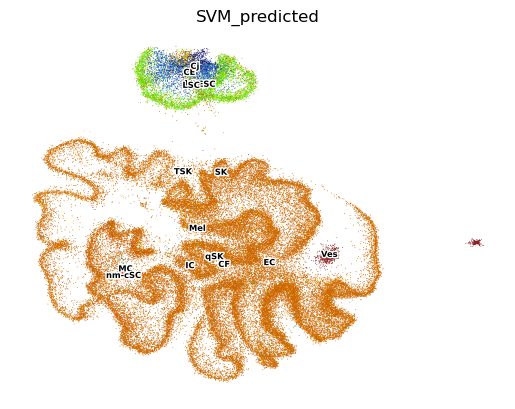

In [30]:
sc.pl.umap(adata, color='SVM_predicted', legend_loc='on data',
           frameon=False, legend_fontsize=6, legend_fontoutline=2, palette = category_colors, save = 'cPredictor_celltype.pdf')

/vol/mbconda/imarais/miniconda3/envs/SVMrej/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


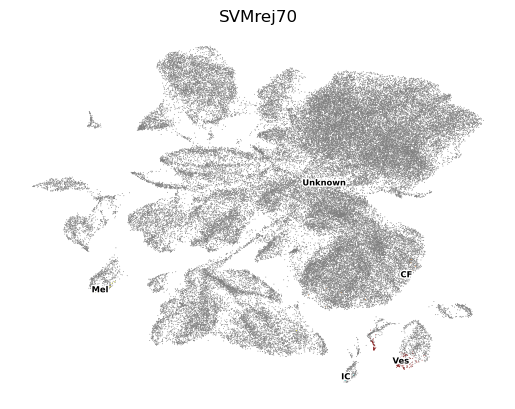

In [30]:
sc.pl.umap(adata, color='SVMrej70', legend_loc='on data',
           frameon=False, legend_fontsize=6, legend_fontoutline=2, palette = category_colors ,save = 'SVMrej70_celltype.pdf')

/vol/mbconda/imarais/miniconda3/envs/SVMrej/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


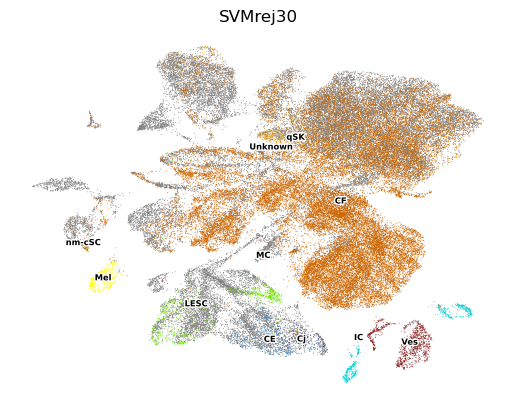

In [31]:
sc.pl.umap(adata, color='SVMrej30', legend_loc='on data',
           frameon=False, legend_fontsize=6, legend_fontoutline=2, palette = category_colors, save = 'SVMrej30_celltype.pdf')

/vol/mbconda/imarais/miniconda3/envs/SVMrej/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


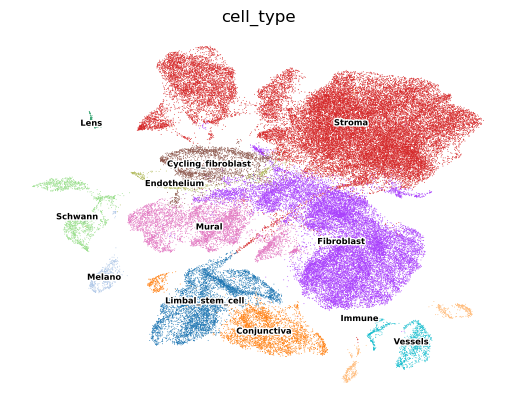

In [33]:
sc.pl.umap(adata, color='cell_type', legend_loc='on data',
           frameon=False, legend_fontsize=6, legend_fontoutline=2)

/vol/mbconda/imarais/miniconda3/envs/SVMrej/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


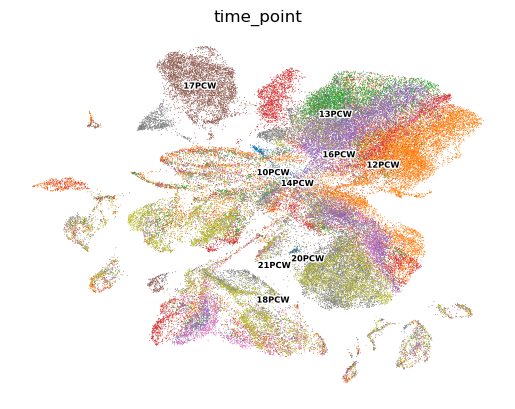

In [34]:
sc.pl.umap(adata, color='time_point', legend_loc='on data',
           frameon=False, legend_fontsize=6, legend_fontoutline=2)